# GUSAIA

In [1]:
!git clone https://github.com/JunaidMuzamal/GUSAIA

fatal: destination path 'GUSAIA' already exists and is not an empty directory.


In [2]:
%cd GUSAIA

/content/GUSAIA


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from gusaia import *

In [4]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Tesla T4 (UUID: GPU-e0f9e6c1-95ca-ea6f-4df7-df6953775f37)


## EDA - Data Pre-Processing

### Download dataset

In [5]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

input/SWaT_Dataset_Normal_v1.csv
[==================================================] 163.77MB/163.77MB
input/SWaT_Dataset_Attack_v0.csv
[==================================================] 127.27MB/127.27MB


### Normal period

In [6]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(495000, 51)

In [7]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [ ]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [9]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(449919, 51)

In [10]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [11]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [12]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [13]:
window_size=12

In [14]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [15]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [16]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = GusaiaC(w_size, z_size)
model = to_device(model,device)

In [17]:
history = fit(N_EPOCHS,model,train_loader,val_loader)

Epoch 0, D1_loss: 0.0248, D2_loss: 0.0251
Epoch 1, D1_loss: 0.0265, D2_loss: -0.0046
Epoch 2, D1_loss: 0.0141, D2_loss: -0.0054
Epoch 3, D1_loss: 0.0128, D2_loss: -0.0073
Epoch 4, D1_loss: 0.0356, D2_loss: -0.0281
Epoch 5, D1_loss: 0.0400, D2_loss: -0.0330
Epoch 6, D1_loss: 0.0449, D2_loss: -0.0389
Epoch 7, D1_loss: 0.0475, D2_loss: -0.0406
Epoch 8, D1_loss: 0.0535, D2_loss: -0.0444
Epoch 9, D1_loss: 0.0551, D2_loss: -0.0469
Epoch 10, D1_loss: 0.0460, D2_loss: -0.0404
Epoch 11, D1_loss: 0.0539, D2_loss: -0.0495
Epoch 12, D1_loss: 0.0571, D2_loss: -0.0531
Epoch 13, D1_loss: 0.0603, D2_loss: -0.0564
Epoch 14, D1_loss: 0.0618, D2_loss: -0.0581
Epoch 15, D1_loss: 0.1214, D2_loss: -0.1101
Epoch 16, D1_loss: 0.1213, D2_loss: -0.1118
Epoch 17, D1_loss: 0.1248, D2_loss: -0.1157
Epoch 18, D1_loss: 0.1246, D2_loss: -0.1160
Epoch 19, D1_loss: 0.1248, D2_loss: -0.1167
Epoch 20, D1_loss: 0.1252, D2_loss: -0.1175
Epoch 21, D1_loss: 0.1254, D2_loss: -0.1180
Epoch 22, D1_loss: 0.1256, D2_loss: -0.1186

In [25]:
def plot_history_gusaia(history):
    D1Loss = [x['D1_val_loss'] for x in history]
    D2Loss = [x['D2_val_loss'] for x in history]
    plt.plot(D1Loss, '-x', label="Decoder- A loss ")
    plt.plot(D2Loss, '-x', label="Decoder- B loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Val Loss')
    plt.grid()
    plt.show()

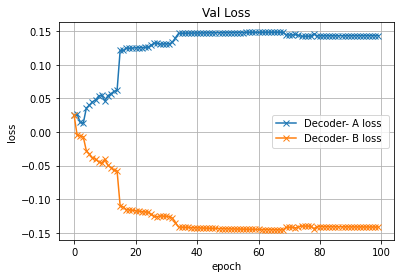

In [27]:
plot_history_gusaia(history)

In [30]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [31]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [32]:
results=validate(model,test_loader)

In [33]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [34]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [35]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

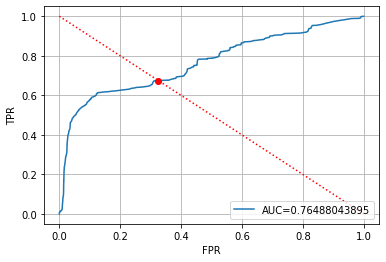

In [36]:
threshold=ROC(y_test,y_pred)

In [ ]:
confusion_matrix(y_test,y_pred)